c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


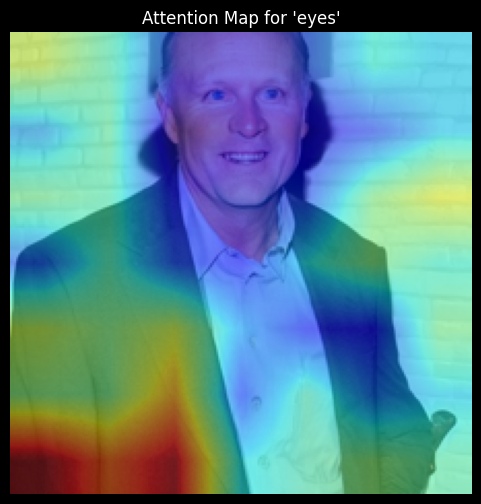

In [ ]:
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. CLIP 모델과 프로세서 로드
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# 2. 샘플 입력 데이터 처리
image_path = "image/2201_1922-06-19_1955.jpg"
text = "eyes"

# PIL.Image로 이미지 열기
image = Image.open(image_path).resize((224, 224))  # CLIP은 일반적으로 224x224 이미지를 사용

inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)

# 3. 이미지와 텍스트 임베딩 추출 및 프로젝션 적용
with torch.no_grad():
    # Vision 모델에서 이미지 패치 임베딩 추출
    image_outputs = model.vision_model(pixel_values=inputs["pixel_values"], output_hidden_states=True)
    image_patch_embeddings = image_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size_v]

    # 첫 번째 토큰(cls_token)을 제외한 패치 임베딩 추출
    patch_embeddings = image_patch_embeddings[:, 1:, :]  # Shape: [batch_size, num_patches, hidden_size_v]

    # 이미지 패치 임베딩에 프로젝션 레이어 적용
    patch_embeddings_proj = model.visual_projection(patch_embeddings)  # Shape: [batch_size, num_patches, projection_dim]

    # Text 모델에서 텍스트 임베딩 추출
    text_outputs = model.text_model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], output_hidden_states=True)
    text_embedding = text_outputs.last_hidden_state[:, 0, :]  # CLS 토큰 임베딩, shape: [batch_size, hidden_size_t]

    # 텍스트 임베딩에 프로젝션 레이어 적용
    text_embedding_proj = model.text_projection(text_embedding)  # Shape: [batch_size, projection_dim]

    # 임베딩 정규화 (코사인 유사도 계산을 위해)
    patch_embeddings_proj = patch_embeddings_proj / patch_embeddings_proj.norm(dim=-1, keepdim=True)
    text_embedding_proj = text_embedding_proj / text_embedding_proj.norm(dim=-1, keepdim=True)

    # 각 패치 임베딩과 텍스트 임베딩 사이의 유사도 계산
    similarity = torch.matmul(patch_embeddings_proj, text_embedding_proj.unsqueeze(-1)).squeeze(-1)  # Shape: [batch_size, num_patches]

# 4. Attention Map 생성 및 시각화
# 패치 수 계산 (ViT-B/32의 경우 7x7 패치)
num_patches = patch_embeddings.shape[1]  # 49
grid_size = int(num_patches ** 0.5)  # 7

# 유사도 스코어를 2D Attention Map으로 변환
attention_map = similarity[0].reshape(grid_size, grid_size).detach().cpu().numpy()

# Attention Map Normalize
attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

# Attention Map 크기를 원본 이미지 크기에 맞게 보간
attention_map_resized = torch.nn.functional.interpolate(
    torch.tensor(attention_map).unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze().numpy()

# 시각화
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Attention Map for '{text}'")
plt.show()



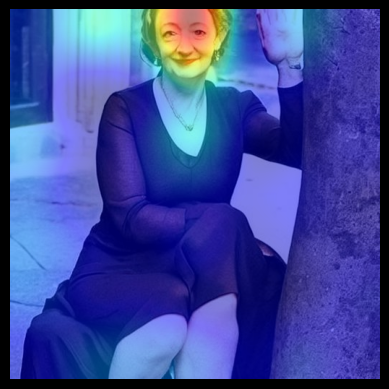

In [8]:
import torch
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 모델과 프로세서를 로드합니다.
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 입력 이미지를 로드합니다.
image_url = "https://raw.githubusercontent.com/KimEunOh/image/main/image/1020922_1950-01-16_2012.jpg"  # 여기에 이미지 URL을 입력하거나 로컬 이미지 경로를 사용하세요.
image = Image.open(requests.get(image_url, stream=True).raw)

# 텍스트 입력을 정의합니다.
text = "body"

# 입력 데이터를 준비합니다.
inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True)

# 모델에 입력 데이터를 통과시키고 attention을 출력하도록 설정합니다.
outputs = model(**inputs, output_attentions=True)
vision_attentions = outputs.vision_model_output.attentions  # Vision Transformer의 attention 출력

# Attention Rollout을 계산하는 함수를 정의합니다.
def compute_attention_rollout(attentions, discard_ratio=0.0):
    batch_size = attentions[0].size(0)
    seq_len = attentions[0].size(-1)
    device = attentions[0].device

    result = torch.eye(seq_len, device=device).unsqueeze(0).repeat(batch_size, 1, 1)

    for attn in attentions:
        attn_heads_fused = attn.mean(dim=1)  # 헤드들 간의 평균 계산, shape: (batch_size, seq_len, seq_len)

        # 가장 낮은 attention 값을 가진 부분을 제거합니다.
        if discard_ratio > 0:
            flat = attn_heads_fused.view(batch_size, -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim=-1, largest=False)
            flat.scatter_(1, indices, 0)
            attn_heads_fused = flat.view_as(attn_heads_fused)

        # 스킵 연결을 추가하고 정규화합니다.
        attn_heads_fused = attn_heads_fused + torch.eye(seq_len, device=device).unsqueeze(0)
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)

        result = torch.bmm(result, attn_heads_fused)

    return result

# Attention Rollout을 계산합니다.
rollout = compute_attention_rollout(vision_attentions)

# [CLS] 토큰에 대한 마스크를 추출합니다.
mask = rollout[:, 0, 1:]  # [CLS] 토큰을 제외한 나머지 토큰에 대한 attention, shape: (batch_size, seq_len - 1)

# 배치에서 첫 번째 이미지에 대한 마스크를 선택합니다.
mask = mask[0]

# 마스크를 이미지의 패치 크기에 맞게 재구성합니다.
num_patches = mask.size(-1)
patch_size = model.config.vision_config.patch_size
image_size = model.config.vision_config.image_size
grid_size = image_size // patch_size  # 예: 224 // 32 = 7

mask = mask.reshape(grid_size, grid_size).detach().cpu().numpy()
mask = cv2.resize(mask, (image.size[0], image.size[1]), interpolation=cv2.INTER_CUBIC)
mask = mask / mask.max()  # 정규화

# 원본 이미지 위에 마스크를 시각화합니다.
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()
